2023-12-12 Meeting

- Use click rate everywhere
- Implement Causal Model: + Reading
    - We divide every click rate by the article mean and the plug it in regression
    - We demean every headline by the article mean and then divide by the population mean
- Make Regplot https://seaborn.pydata.org/generated/seaborn.regplot.html - should expect a clear upwards trend
- Taking the predictions of the correlational model and comparing the top and least rated

In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.linear_model import RidgeCV, LogisticRegression, LinearRegression
from torch.utils.data import DataLoader, TensorDataset
import csv
import torch 
import pickle
import random
from sklearn.metrics import accuracy_score
from scipy.stats import spearmanr
import math

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#cpu/gpu
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

No GPU available, using the CPU instead.


In [3]:
#Load data
df = pd.read_csv("upworthy-archive-confirmatory-packages-03.12.2020.csv", low_memory=False)
#Delete some unnecessary columns
delete_cols = ["created_at","updated_at","share_text","square"]
df = df.drop(columns=delete_cols)
#Create a new column for clickrate
df["clickrate"] = round((df["clicks"]/ df["impressions"]),ndigits=3)
print(df.groupby(["clickability_test_id"]).count().mean()) #average of 4.64 packages within one test
print(df.groupby(["clickability_test_id","eyecatcher_id"]).count().mean()) #average of 2.11 packages with the same eyecatcher id and same clickability_test_id
# Make tensor
clickrate = torch.tensor(df.clickrate.values)

Unnamed: 0       4.641032
excerpt          4.147870
headline         4.641032
lede             4.638130
slug             4.641032
eyecatcher_id    4.635272
impressions      4.641032
clicks           4.641032
significance     4.641032
first_place      4.641032
winner           4.641032
test_week        4.641032
clickrate        4.641032
dtype: float64
Unnamed: 0      2.117931
excerpt         1.892597
headline        2.117931
lede            2.116605
slug            2.117931
impressions     2.117931
clicks          2.117931
significance    2.117931
first_place     2.117931
winner          2.117931
test_week       2.117931
clickrate       2.117931
dtype: float64


In [4]:
#Load prerun embeddings of all-mpnet-base-v2
with open('all-mpnet-base-v2_embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['headlines']
    stored_embeddings = stored_data['embeddings']

## 1.R Predicting clickrate from headline embeddings with ridge regression

In [6]:
# Model
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clickrate, test_size=0.2)

In [10]:
# Ridge Model
ridge_model =RidgeCV(alphas=[0.001,0.002,0.005,0.01,0.05,0.07,0.2,0.4,0.6, 1, 10],store_cv_values=True)
ridge_model.fit(X_train, y_train)
ridge_model.score(X_train,y_train)
predictions = ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions)
print("Ridge Regression MSE for click difference:", rmse)
print("Ridge Regression R2 for click difference:", r2_score(y_true=y_test, y_pred=predictions))

Ridge Regression MSE for click difference: 0.00012034177786820873
Ridge Regression R2 for click difference: 0.2428571939805506


## 1.L Predicting clickrate from headline embeddings with linear regression

In [9]:
# Linear Model
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, clickrate, test_size=0.2)
linear_model =LinearRegression()
linear_model.fit(X_train, y_train)
linear_model.score(X_train,y_train)
predictions = linear_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Linear Regression MSE for clicks:", rmse)
print("Linear Regression R2 for clicks:", r2_score(y_true=y_test, y_pred=predictions))

Linear Regression MSE for clicks: 0.010978369524528112
Linear Regression R2 for clicks: 0.24170696578311657


## 1.V Visualizing predicted clicks vs actual clicks

0.04371530259670203


[Text(0, 0.5, 'true clickrate'), Text(0.5, 0, 'predicted clickrate')]

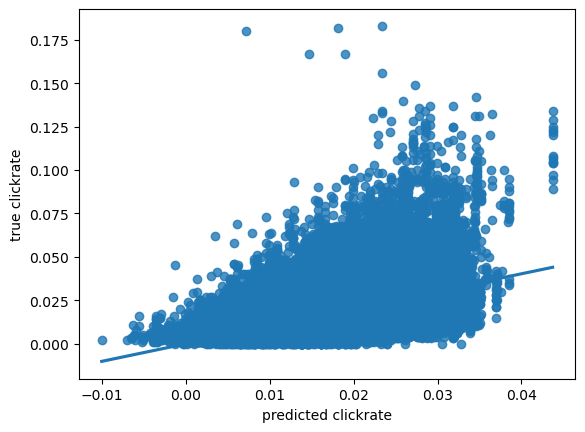

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
# print stuff. 
predictions = ridge_model.predict(stored_embeddings)
print(predictions.max())
# visualize real and predicted values
fig, ax = plt.subplots()
sns.regplot(x = predictions, y = df.clickrate, ax=ax)
ax.set(ylabel = 'true clickrate', xlabel = 'predicted clickrate')

## 2.R Causal Model 

Implement Causal Model: + Reading
    - We divide every click rate by the article mean and the plug it in regression
    - We demean every headline by the article mean and then divide by the population mean

## X. Compare top / bottom 20 causal model with correlational model 
Implement Causal Model: + Reading
    - We divide every click rate by the article mean and the plug it in regression
    - We demean every headline by the article mean and then divide by the population mean

In [ ]:
last20_pred = df.sort_values(["predictions_clickrate_all"],ascending=True).loc[:,['headline']][:20]
last20_true = df.sort_values(["clickrate"],ascending=True).loc[:,['headline']][:20]
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(last20_pred.style.set_caption('Last 20 Predicted'))
    last20_pred.info()
with widget2:
    display.display(last20_true.style.set_caption('Last 20 True'))
    last20_true.info()


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    

box = widgets.HBox([widget1, widget2], layout=box_layout)
box

In [ ]:
#Checking for intersection
np.intersect1d(last20_pred.values,last20_true.values)

array([], dtype=object)